<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import os
import pandas as pd 
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt 

from urllib.request import urlretrieve
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.utils import shuffle
from pandas.core.common import SettingWithCopyWarning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score, roc_auc_score 
# отключить некритические предупреждения в коде
import warnings
warnings.filterwarnings("ignore")

## Исследование задачи

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
# получение первых 5 строк таблицы df
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
df.isna().sum()


RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [6]:
df.duplicated().sum()


0

Описание данных
:
RowNumber — индекс строки в данных

CustomerId  — уникальный идентификатор клиента

Surname — фамилия

CreditScore — кредитный рейтинг

Geography — страна проживания

Gender — пол

Age — возраст

Tenure — сколько лет человек является клиентом банка

Balance — баланс на счёте

NumOfProducts — количество продуктов банка, используемых клиентом

HasCrCard — наличие кредитной карты

IsActiveMember — активность клиента

EstimatedSalary — предполагаемая зарплата


Целевой признак Exited — факт ухода клиента

In [7]:
# Посмотрим тип данных в столбцах
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [8]:
df.columns = map(str.lower, df.columns)# приводим названия столбцов в нижний регистр
df.head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [9]:
#  значения по столбцу Geography
df['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [10]:
#  значения по столбцу Gender
df['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [11]:
#  значения по столбцу Tenure
df['tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

In [12]:
#  значения по столбцу NumOfProducts
df['numofproducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: numofproducts, dtype: int64

In [13]:
# деление по целевому признаку
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [14]:
# клиенты с нулевым балансом
len(df.query('balance == 0'))

3617

In [15]:
#наличие кредитных карт
df['hascrcard'].value_counts()

1    7055
0    2945
Name: hascrcard, dtype: int64

In [16]:
#активность клиентов
df['isactivemember'].value_counts()

1    5151
0    4849
Name: isactivemember, dtype: int64

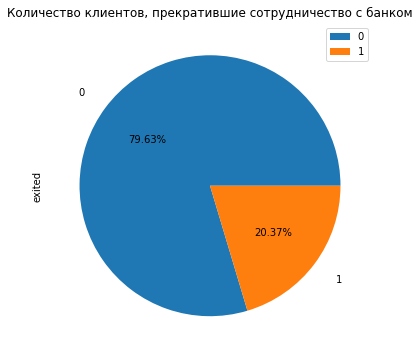

In [17]:
def make_pie_plot(data, name):
    counts = data.value_counts()
    counts.plot.pie(legend=True, labeldistance=1.2, autopct='%1.2f%%', figsize=(12,6), title=name)
    plt.show()
make_pie_plot(df['exited'], 'Количество клиентов, прекратившие сотрудничество с банком')
# 1 = Да, 0 = Нет

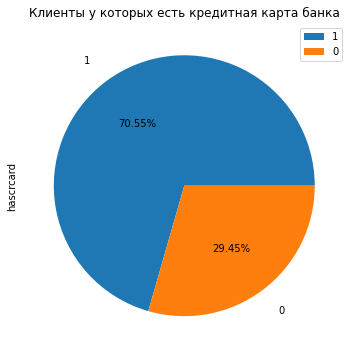

In [18]:
make_pie_plot(df['hascrcard'], 'Клиенты у которых есть кредитная карта банка')

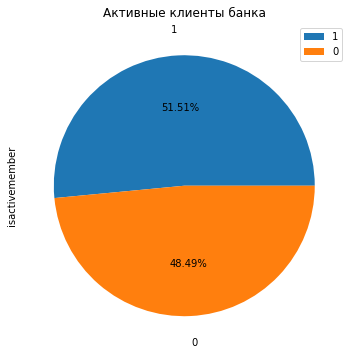

In [19]:
make_pie_plot(df['isactivemember'], 'Активные клиенты банка')

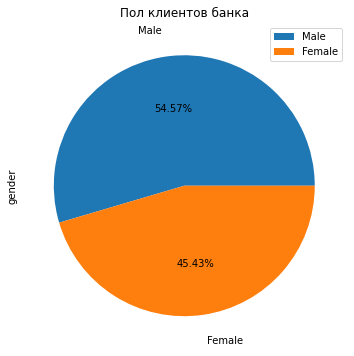

In [20]:
make_pie_plot(df['gender'], 'Пол клиентов банка')

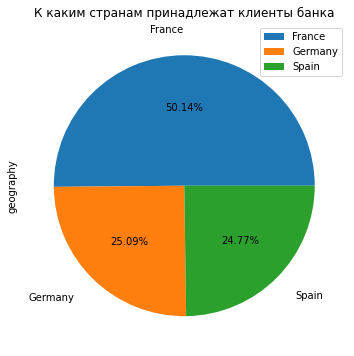

In [21]:
make_pie_plot(df['geography'], 'К каким странам принадлежат клиенты банка')

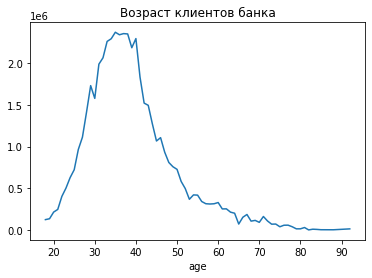

In [22]:
df.pivot_table(index='age', values='rownumber', aggfunc='sum').sort_values('age', ascending=False).plot(legend=False, title='Возраст клиентов банка')
plt.show()

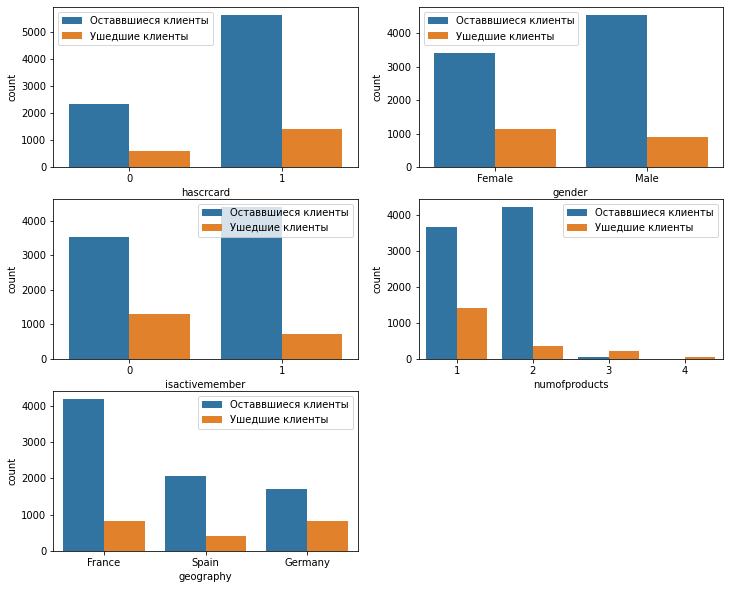

In [23]:
plt.figure(figsize=(12,10))
columns = ['hascrcard', 'gender', 'isactivemember', 'numofproducts', 'geography']
for i in range(5):
    plt.subplot(3, 2, i+1)
    sb.countplot(x=columns[i], hue='exited', data=df)
    plt.xticks(rotation=0)
    plt.legend(["Оставвшиеся клиенты", "Ушедшие клиенты"])
plt.show()

10000 уникальных id

страны и количество клиентов банка:
France 5014
Germany 2509
Spain 2477

количество мужчин и женщин:
Male 5457
Female 4543

клиенты с нулевым балансом: 3617

количество недвижимости у клиентов от 0 до 10

всего 4 продукта банка и количество клиентов, использующих их:
1 5084
2 4590
3 266
4 60

Следующие столбцы имеют булевые значения:
hascrcard
isactivemember
exited

Самому молодому клиенту банка 18 лет, самому старому 92

Клиенты, ушедшие из банка: 2037

Клиенты у которых есть кредитные карты банка 2945

Активные клиенты банка 4849

In [24]:
# удалим колонки CustomerId,Surname,RowNumber. Предполагаем , что id и фамилия клиента совершенно не влияют на факт ухода клиента
df = df.drop(['rownumber','customerid','surname'], axis=1)

In [25]:
# посмотрим значения по столбцу Tenure  и приведем столбец в целочисленный тип
df['tenure'].value_counts().astype('int64')

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: tenure, dtype: int64

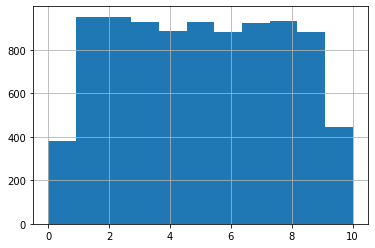

In [26]:
# построим гистограмму по столбцу Tenure
df['tenure'].hist(bins=11)
plt.show()

В связи с тем, что природа пропусков неизвестна заполним случайными числами, чтобы не влиять на распределение.

In [27]:
data = (np.random.randint(0,10,size=df['tenure'].isna().sum()))
df.loc[df['tenure'].isna(),'tenure']=data

In [28]:
df.isna().sum()

creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

In [29]:
numeric = ['creditscore', 'age','tenure', 'balance', 'numofproducts', 'estimatedsalary']

In [30]:
# посмотрим корреляцию факторов
df.loc[:,numeric].corr()

,creditscore,age,tenure,balance,numofproducts,estimatedsalary
creditscore,1.000000,-0.003965,0.001263,0.006268,0.012238,-0.001384
age,-0.003965,1.000000,-0.012570,0.028308,-0.030680,-0.007201
tenure,0.001263,-0.012570,1.000000,-0.009575,0.013231,0.004411
balance,0.006268,0.028308,-0.009575,1.000000,-0.304180,0.012797
numofproducts,0.012238,-0.030680,0.013231,-0.304180,1.000000,0.014204
estimatedsalary,-0.001384,-0.007201,0.004411,0.012797,0.014204,1.000000


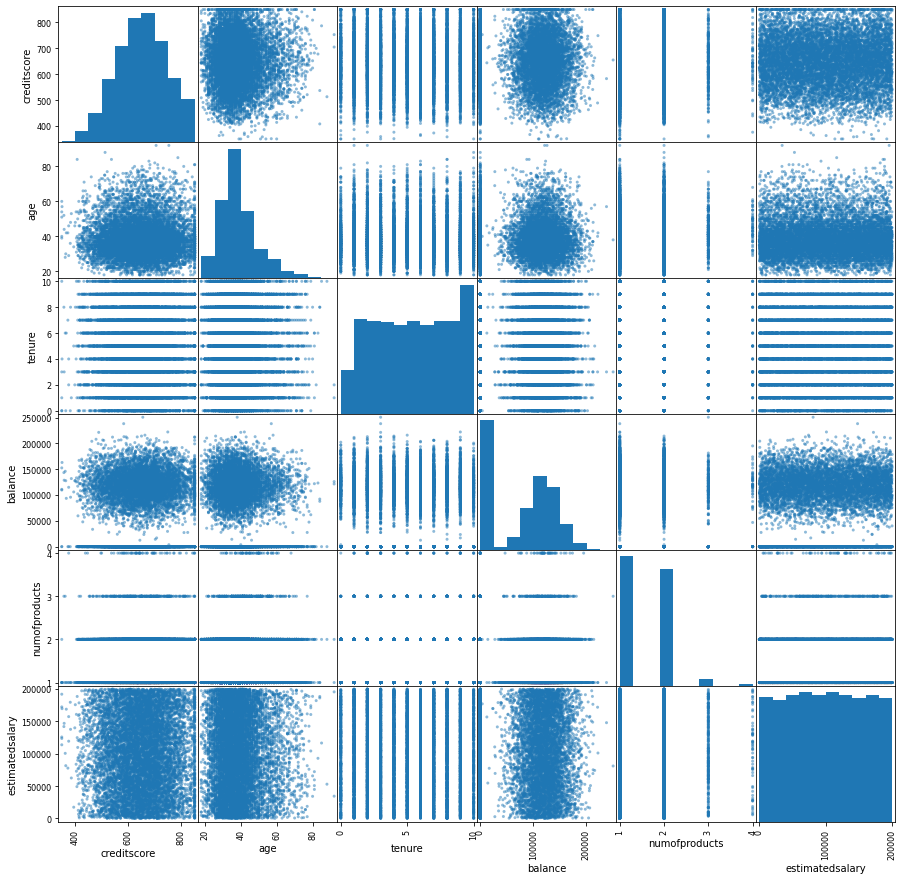

In [31]:
pd.plotting.scatter_matrix(df.loc[:,numeric],figsize=(15,15))
plt.show()

Корреляции между столбцами не обнаружено.

In [32]:
# Выполним прямое кодирование

data_ohe = pd.get_dummies(df, drop_first = True)

In [33]:
 #Выполним разделение выборки на обучающу валидационную и тестовую

features = data_ohe.drop(['exited'], axis = 1)
target = data_ohe['exited']


In [34]:
# Получение пропорции 60:40

features_train, features_valid, target_train, target_valid= train_test_split(
    features, target, test_size = 0.40, random_state = 12345)
print(features_train.shape)
print(features_valid.shape)

(6000, 11)
(4000, 11)


In [35]:
# Разделение 40 % на две части

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size = 0.50, random_state = 12345)
print(features_test.shape)
print(features_test.shape)


(2000, 11)
(2000, 11)


Нулевой класс превышает первый на 59.26%


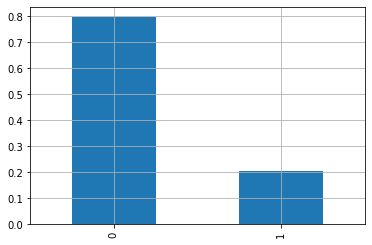

In [36]:
class_exited = target.value_counts(normalize = (0,1))
class_exited.plot(kind = 'bar', grid = True)
print('Нулевой класс превышает первый на {:.2%}'.format(class_exited[0] - class_exited[1]))
plt.show()

In [37]:
features[target == 0].shape, features[target == 1].shape

((7963, 11), (2037, 11))

In [38]:
# Масштабирование признаков
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [39]:
# Выберем 3 модели которые будем обучать и выберем лучшую из них для доработки гиперпараметров

warnings.filterwarnings("ignore", category=FutureWarning)

best_model = {'Логистическая регрессия' : LogisticRegression(solver = 'liblinear', random_state = 12345), 
              'Случайный лес': RandomForestClassifier(random_state = 12345), 
              'Решающее дерево': DecisionTreeClassifier(random_state = 12345)}

for name, model in best_model.items():
    model = model
    model.fit(features_train, target_train)
    predict = model.predict(features_valid)
    print(name, 'F1:', f1_score(target_valid, predict))
    
    # Добавлен рассчет AUC_ROC
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

    print(name, 'AUC_ROC:', auc_roc)

Логистическая регрессия F1: 0.33783783783783783
Логистическая регрессия AUC_ROC: 0.7588314107876286
Случайный лес F1: 0.574436090225564
Случайный лес AUC_ROC: 0.8410656064941113
Решающее дерево F1: 0.5000000000000001
Решающее дерево AUC_ROC: 0.6832003580955607


Исходя из исследования мы обнаружили нарушение баланса классов, который необходимо будет в дальнейшем устранить. В нашей задаче меток с классом 0 > чем меток с классом 1. Также мы выяснили, что без учета баланса классов лучше всего в предсказании себя проявляет Случайный лес(F1 = 0,57).Худшие результаты показала модель Логистической регрессии(F1 = 0.33).Далее мы её рассматривать не будем.

## Борьба с дисбалансом

Построение моделей при помощи (upsampling)

In [40]:
# Cбалансируем классы. Увеличим в 4 раза размерность 1 класса

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

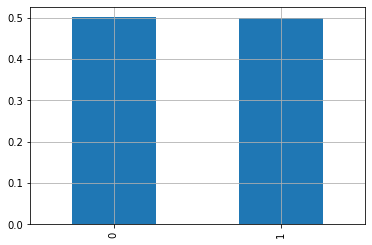

In [41]:
# Проверим, правльно ли мы сбалансировали классы

class_exited = target_train_upsampled.value_counts(normalize = (0,1))
class_exited.plot(kind = 'bar', grid = True)
plt.show()

In [42]:
for name, model in best_model.items():
    model = model
    model.fit(features_train_upsampled, target_train_upsampled)
    predict = model.predict(features_valid)
    print(name, 'F1:', f1_score(target_valid, predict))
  

Логистическая регрессия F1: 0.4888507718696398
Случайный лес F1: 0.5957446808510638
Решающее дерево F1: 0.4902439024390244


Без настройки гиперпараметров, себя также лучше всего показывает на сбалансированных классах модель Случайного леса

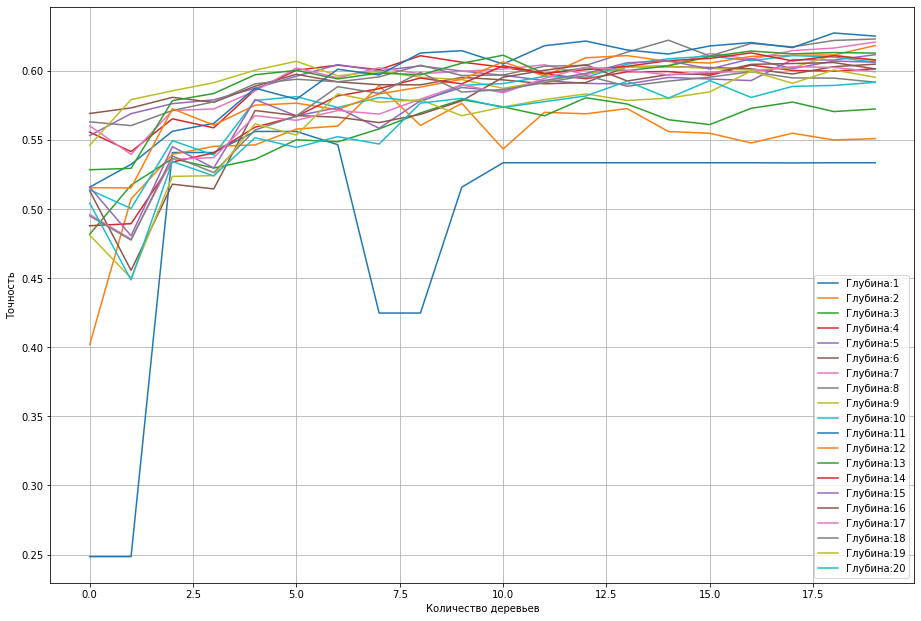

Лучшая точность:  0.6275395033860045 при глубине = 11 и количестве деревьев = 19
Значение AUC_ROC: 0.8433709978889298


In [43]:
# Случайный лес 

best_model_forest = None
rand_forest_res = {}
best_result = 0
best_est = 0
best_depth = 0
for depth in range(1,21):
    f_1_rand_forest = []

  
    for est in range(1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model.fit(features_train_upsampled, target_train_upsampled)
        prediction = model.predict(features_valid)
        result = f1_score(target_valid, prediction)
        f_1_rand_forest.append(result)
        
        if best_result < result:
            best_result = result
            best_est = est
            best_depth = depth
            best_model_forest = model
    rand_forest_res.update({depth : f_1_rand_forest})
data_rand_forest = pd.DataFrame(rand_forest_res)    
fig = plt.figure()

ax = fig.add_axes([0,0,2,2])

ax.grid()
ax.set_xlabel('Количество деревьев') 
ax.set_ylabel('Точность')

for name_column in range(len(data_rand_forest)):
    ax.plot(data_rand_forest.index, data_rand_forest[name_column + 1], label = 'Глубина:' + str(name_column + 1))
    
ax.legend()
plt.show()

print('Лучшая точность: ', data_rand_forest.max().max(), 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth, best_est))

# Добавлено значение AUC_ROC
probabilities_valid = best_model_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Значение AUC_ROC:', auc_roc)




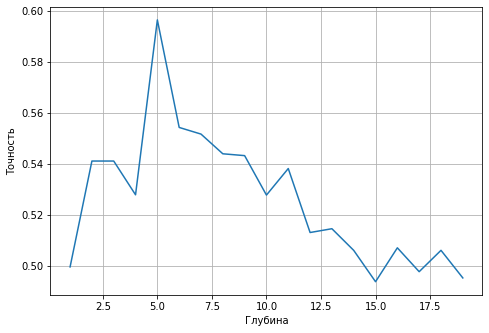

Лучшая точность: 0.5963791267305644 cо значением глубины = 5
Значение AUC_ROC: 0.8310244134068074


In [44]:
# Решающее дерево

best_result = 0
depth = 0
model_up = None
f_1_tree = []

for i in range(1, 20):    
    model = DecisionTreeClassifier(random_state = 12345, max_depth = i)
    model.fit(features_train_upsampled, target_train_upsampled)
    predict = model.predict(features_valid)
    score = f1_score(target_valid, predict)
    f_1_tree.append(score)
    if score > best_result:
        best_result = score
        depth = i
        model_up = model
f_1_tree = pd.Series(f_1_tree)      

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.grid()
ax.set_xlabel('Глубина')
ax.set_ylabel('Точность')
    
ax.plot(f_1_tree.index + 1, f_1_tree)
plt.show()

print("Лучшая точность:", best_result, 'cо значением глубины =', depth)

probabilities_valid = model_up.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Значение AUC_ROC:', auc_roc)

 При настройке гиперпараметров мы добились максимального показателя метрики F1 у модели Случайного леса. Значение AUC_ROC, при данных настройках гиперпараметров у модели Случайный лес 0,821 а у модели Решающего дерева 0,831.

Построение моделей при помощи (downsampling)

In [45]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25)

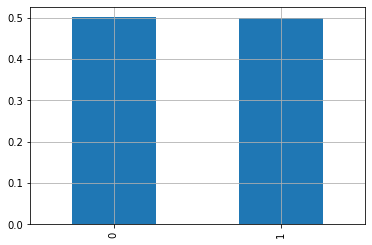

In [46]:
# Проверим, правльно ли мы сбалансировали классы

class_exited = target_train_downsampled.value_counts(normalize = (0,1))
class_exited.plot(kind = 'bar', grid = True)
plt.show()

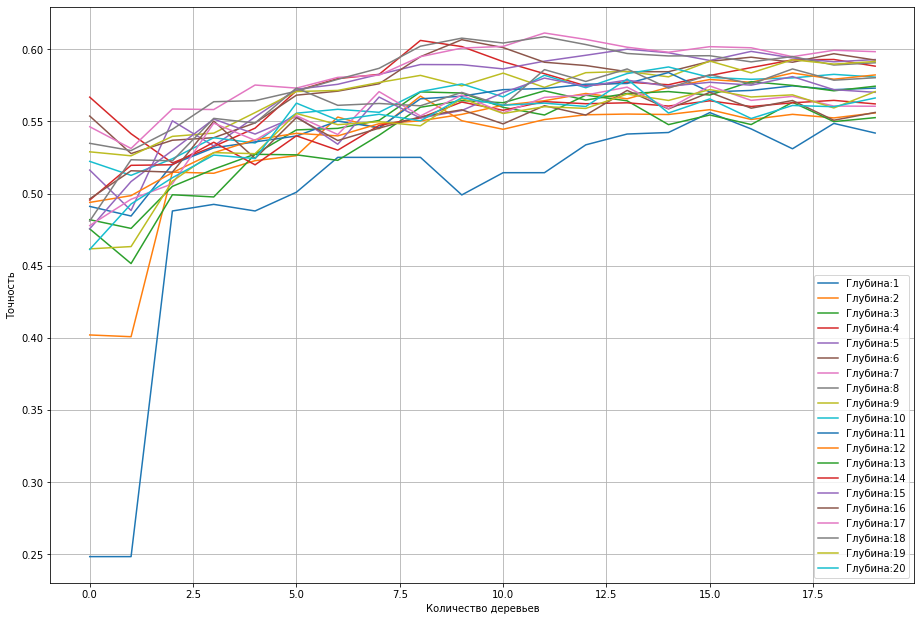

Лучшая точность:  0.6112185686653773 при глубине = 7 и количестве деревьев = 12
Значение AUC_ROC: 0.8469663196607771


In [47]:
# Случайный лес (голосование)

best_model_rand_forest = None
rand_forest_res = {}
best_result = 0
best_est = 0
best_depth = 0

for depth in range(1,21):
    f_1_rand_forest = []
    for est in range(1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model.fit(features_train_downsampled, target_train_downsampled)
        prediction = model.predict(features_valid)
        result = f1_score(target_valid, prediction)
        f_1_rand_forest.append(result)
        
        if best_result < result:
            best_result = result
            best_est = est
            best_depth = depth
            best_model_rand_forest = model
        
    rand_forest_res.update({depth : f_1_rand_forest})

data_rand_forest = pd.DataFrame(rand_forest_res)

fig = plt.figure()

ax = fig.add_axes([0,0,2,2])

ax.grid()
ax.set_xlabel('Количество деревьев') 
ax.set_ylabel('Точность')

for name_column in range(len(data_rand_forest)):
    ax.plot(data_rand_forest.index, data_rand_forest[name_column + 1], label = 'Глубина:' + str(name_column + 1))
    
ax.legend()
plt.show()

print('Лучшая точность: ', data_rand_forest.max().max(), 'при глубине = {0} и количестве деревьев = {1}'.format(best_depth, best_est))

# Добавлено значение AUC_ROC
probabilities_valid = best_model_rand_forest.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Значение AUC_ROC:', auc_roc)

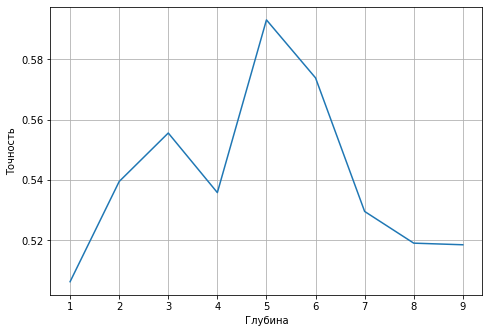

Лучшая точность: 0.5931174089068827 c значением глубины = 5
Значение AUC_ROC: 0.82291433531536


In [48]:
# Решающее дерево

best_result = 0
depth = 0
model_down = None
f_1_tree = []

for i in range(1, 10):    
    model = DecisionTreeClassifier(random_state = 12345, max_depth = i)
    model.fit(features_train_downsampled, target_train_downsampled)
    predict = model.predict(features_valid)
    score = f1_score(target_valid, predict)
    f_1_tree.append(score)
    if score > best_result:
        best_result = score
        depth = i
        model_down = model
f_1_tree = pd.Series(f_1_tree)        
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.grid()
ax.set_xlabel('Глубина')
ax.set_ylabel('Точность')
    
ax.plot(f_1_tree.index + 1, f_1_tree)
plt.show()

print("Лучшая точность:", best_result, 'c значением глубины =', depth)

probabilities_valid = model_down.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('Значение AUC_ROC:', auc_roc)

И хотя модель Случайного леса работает медленнее модели Решающего дерева, она показывает лучшую точность с F1 мерой и значением AUC_ROC: 0.851 у модели Случайного леса и 0,822 у модели Решающего дерева. Проверим эти модели на тестовой выборке.

## Тестирование модели

In [49]:
#Случайный лес upsampling
predict = best_model_forest.predict(features_test)
print('Значение F1 меры:', f1_score(target_test, predict))
probabilities_valid=best_model_forest.predict_proba(features_test)
probabilities_one_valid=probabilities_valid[:,1]
fpr_best_model_forest,tpr_best_model_forest,thresholds=roc_curve(target_test,probabilities_one_valid)
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('auc_roc:',auc_roc) 

Значение F1 меры: 0.6108597285067874
auc_roc: 0.8445420352556176


In [50]:
#Решающее дерево upsampling
predict = model_up.predict(features_test)
print('Значение F1 меры:', f1_score(target_test, predict))
probabilities_valid=model_up.predict_proba(features_test)
probabilities_one_valid=probabilities_valid[:,1]
fpr_model_up,tpr_model_up,thresholds=roc_curve(target_test,probabilities_one_valid)
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('auc_roc:',auc_roc) 

Значение F1 меры: 0.5809128630705395
auc_roc: 0.8355347481752318


In [51]:
#Случайный лес downsampling
predict = best_model_rand_forest.predict(features_test)
print('Значение F1 меры:', f1_score(target_test, predict))
probabilities_valid=best_model_rand_forest.predict_proba(features_test)
probabilities_one_valid=probabilities_valid[:,1]
fpr_best_model_rand_forest,tpr_best_model_rand_forest,thresholds=roc_curve(target_test,probabilities_one_valid)
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('auc_roc:',auc_roc) 

Значение F1 меры: 0.586977648202138
auc_roc: 0.8462165196808135


In [52]:
#Решающее дерево downsampling
predict = model_down.predict(features_test)
print('Значение F1 меры:', f1_score(target_test, predict))
probabilities_valid=model_down.predict_proba(features_test)
probabilities_one_valid=probabilities_valid[:,1]
fpr_model_down,tpr_model_down,thresholds=roc_curve(target_test,probabilities_one_valid)
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('auc_roc:',auc_roc) 

Значение F1 меры: 0.6074380165289257
auc_roc: 0.8371844976022043


Строим ROC-кривую.

<Figure size 432x288 with 0 Axes>

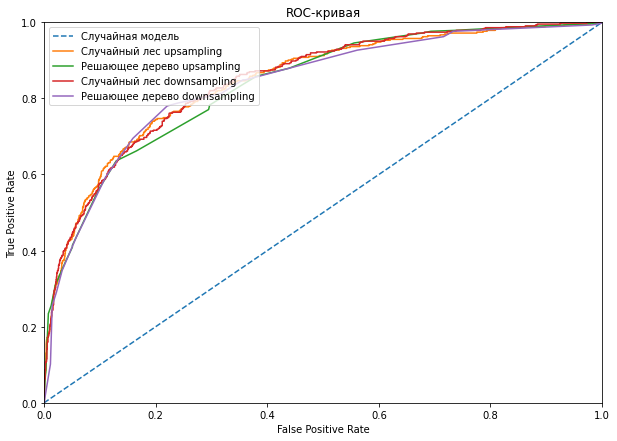

In [53]:
plt.figure()
plt.figure(figsize=(10,7))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot(fpr_best_model_forest,tpr_best_model_forest)
plt.plot(fpr_model_up,tpr_model_up)
plt.plot(fpr_best_model_rand_forest,tpr_best_model_rand_forest)
plt.plot(fpr_model_down,tpr_model_down)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(('Случайная модель','Случайный лес upsampling','Решающее дерево upsampling','Случайный лес downsampling','Решающее дерево downsampling'),
           loc= 'upper left') 
plt.show()

Значение площади под кривой. На сколько наша модель отличается от случайной

Лучшее значение метрики auc roc: 0.847 у модели Случайный лес сбалансированной техникой downsampling

## Вывод
В данном проекте проделаны и выполнены следующие шаги:

Первичная предобработка данных;

Прямое кодирование категориальных переменных;

Произведено масштабирование;

Проведена проверка на баланс классов;

Сбалансированы классы;

Опробованы несколько моделей для решения поставленной задачи;

Найдены критерии при которых мы получаем F1 меру > 0.59;

Совместно с F1 мерой была найдена метрика AUC_ROC, которая дала нам понять на сколько мы улучшили модель относительно случайной.

Как показало данное исследование лучшей моделью для решения поставленной задачи оказалась модель Решающего дерева, сбалансированная техникой downsampling. При настроенных гиперпараметрах мера  F1  на тестовой выборке составила 0.607, что > 0.59.Цель проекта достигнута.Исходя из того, что на сбалансированных классах лучшие результаты показывала модель Случайного леса upsampling я склонен сделать вывод, что в нашей задаче решающее значение играет настройка гиперпараметров.